#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/AI_딥러닝/mini_project6_1/'

### **(2) 라이브러리 설치 및 불러오기**

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Dropout
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [6]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [121]:
df = pd.merge(sales, oil_price, how = 'left', on = 'Date')
df = pd.merge(df, orders, how = 'left', on = ['Date', 'Store_ID'])
df = pd.merge(df, stores, how = 'left', on = 'Store_ID')
df = pd.merge(df, products, how = 'left', on = 'Product_ID')

df

,Date,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,City,State,Store_Type,Product_Code,SubCategory,Category,LeadTime,Price
0,2014-01-01,1,0.000,3,NaN,NaN,Saint Paul,\tMinnesota,4,DB001,Beverage,Drink,2,8
1,2014-01-01,1,0.000,5,NaN,NaN,Saint Paul,\tMinnesota,4,FB001,BAKERY,Food,2,6
2,2014-01-01,1,0.000,7,NaN,NaN,Saint Paul,\tMinnesota,4,HC001,Cleaning,Household Goods,2,15
3,2014-01-01,1,0.000,8,NaN,NaN,Saint Paul,\tMinnesota,4,FM001,Yogurt,Food,2,4
4,2014-01-01,1,0.000,10,NaN,NaN,Saint Paul,\tMinnesota,4,GE001,EGGS,Grocery,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934270,2017-02-28,54,24.000,38,54.0,729.0,LA,\tCalifornia,3,DA001,Wine,Drink,2,12
934271,2017-02-28,54,49.222,24,54.0,729.0,LA,\tCalifornia,3,GM001,Meats,Grocery,3,17
934272,2017-02-28,54,12.000,27,54.0,729.0,LA,\tCalifornia,3,HH001,Home Appliances,Household Goods,2,150
934273,2017-02-28,54,59.000,29,54.0,729.0,LA,\tCalifornia,3,FP001,Prepared,Food,2,18


## **(1) 상품 : 3 - Beverage**

In [149]:
df_3 = df[(df['Product_ID']==3) & (df['Store_ID']==44)]
df_3

,Date,Store_ID,Qty,Product_ID,WTI_Price,CustomerCount,City,State,Store_Type,Product_Code,SubCategory,Category,LeadTime,Price
645,2014-01-01,44,0.0,3,NaN,NaN,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
1456,2014-01-02,44,9853.0,3,95.14,4422.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
2267,2014-01-03,44,8647.0,3,93.66,4167.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
3078,2014-01-04,44,15153.0,3,NaN,5341.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
3889,2014-01-05,44,15606.0,3,NaN,5123.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930865,2017-02-24,44,10208.0,3,53.99,4549.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
931676,2017-02-25,44,12361.0,3,NaN,4619.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
932487,2017-02-26,44,10108.0,3,NaN,3877.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8
933298,2017-02-27,44,10006.0,3,54.04,3961.0,Saint Paul,\tMinnesota,1,DB001,Beverage,Drink,2,8


In [150]:
drop_cols = ['Store_ID', 'Product_ID', 'City', 'State', 'Store_Type', 'Product_Code', 'SubCategory', 'Category']

In [151]:
df_3.drop(columns=drop_cols, axis=1, inplace=True)

In [152]:
df_3

,Date,Qty,WTI_Price,CustomerCount,LeadTime,Price
645,2014-01-01,0.0,NaN,NaN,2,8
1456,2014-01-02,9853.0,95.14,4422.0,2,8
2267,2014-01-03,8647.0,93.66,4167.0,2,8
3078,2014-01-04,15153.0,NaN,5341.0,2,8
3889,2014-01-05,15606.0,NaN,5123.0,2,8
...,...,...,...,...,...,...
930865,2017-02-24,10208.0,53.99,4549.0,2,8
931676,2017-02-25,12361.0,NaN,4619.0,2,8
932487,2017-02-26,10108.0,NaN,3877.0,2,8
933298,2017-02-27,10006.0,54.04,3961.0,2,8


In [153]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# 주말 여부 계산
df_3['Weekend'] = df_3['Date'].dt.weekday.isin([5, 6])  # 5: 토요일, 6: 일요일

# 공휴일 여부 계산
cal = calendar()
holidays = cal.holidays(start=df_3['Date'].min(), end=df_3['Date'].max())
df_3['Holiday'] = df_3['Date'].isin(holidays)

# Black Friday 여부 계산
# 추수감사절은 11월 넷째 목요일이므로, Black Friday는 그 다음날 금요일
# 추수감사절은 11월 넷째 목요일
def get_fourth_thursday_of_november(year):
    november_first = pd.Timestamp(year=year, month=11, day=1)
    fourth_thursday = (november_first + pd.offsets.Day((3 - november_first.weekday()) % 7)
                       + pd.offsets.Week(3))
    return fourth_thursday

df_3['B_Friday'] = df_3['Date'].apply(lambda x: x == get_fourth_thursday_of_november(x.year) + pd.Timedelta(days=1))


df_3['Total_sales'] = df_3['Qty'] * df_3['Price']

In [155]:
df_3['target'] = df_3['Qty'].shift(-2)
df_3.drop(columns=['LeadTime'], axis=1, inplace=True)

In [156]:
df_3 = df_3.reset_index(drop=True)

In [157]:
df_3

,Date,Qty,WTI_Price,CustomerCount,Price,Weekend,Holiday,B_Friday,Total_sales,target
0,2014-01-01,0.0,NaN,NaN,8,False,True,False,0.0,8647.0
1,2014-01-02,9853.0,95.14,4422.0,8,False,False,False,78824.0,15153.0
2,2014-01-03,8647.0,93.66,4167.0,8,False,False,False,69176.0,15606.0
3,2014-01-04,15153.0,NaN,5341.0,8,True,False,False,121224.0,7900.0
4,2014-01-05,15606.0,NaN,5123.0,8,True,False,False,124848.0,7188.0
...,...,...,...,...,...,...,...,...,...,...
1147,2017-02-24,10208.0,53.99,4549.0,8,False,False,False,81664.0,10108.0
1148,2017-02-25,12361.0,NaN,4619.0,8,True,False,False,98888.0,10006.0
1149,2017-02-26,10108.0,NaN,3877.0,8,True,False,False,80864.0,14374.0
1150,2017-02-27,10006.0,54.04,3961.0,8,False,False,False,80048.0,NaN


In [158]:
print(df_3['Weekend'].value_counts())
print(df_3['Holiday'].value_counts())
print(df_3['B_Friday'].value_counts())

Weekend
False    823
True     329
Name: count, dtype: int64
Holiday
False    1121
True       31
Name: count, dtype: int64
B_Friday
False    1149
True        3
Name: count, dtype: int64


In [159]:
df_3.isna().sum()

Date               0
Qty                0
WTI_Price        357
CustomerCount      6
Price              0
Weekend            0
Holiday            0
B_Friday           0
Total_sales        0
target             2
dtype: int64

In [161]:
# 'Qty'가 0.0인 경우 'CustomerCount'를 0.0으로 설정
df_3.loc[df_3['Qty'] == 0.0, 'CustomerCount'] = 0.0

In [171]:
df_3['CustomerCount'] = df_3['CustomerCount'].interpolate(method='linear')

In [164]:
df_3['WTI_Price'] = df_3['WTI_Price'].interpolate(method='linear')
df_3['WTI_Price'].fillna(method='bfill', inplace=True)

In [173]:
df_3.dropna(axis=0, inplace=True)

In [201]:
bool_columns = df_3.select_dtypes(include=['bool']).columns
df_3[bool_columns] = df_3[bool_columns].astype(int)

# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [308]:
target = 'target'

x = df_3.drop([target, 'Date'], axis =1)
y = df_3.loc[:, target]

In [309]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=60, shuffle=False)

In [312]:
scaler_x = MinMaxScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)

In [313]:
scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s = scaler_y.transform(y_val.values.reshape(-1,1))

### **2) 모델링**

In [314]:
nfeatures = x_train_s.shape[1]

clear_session()

model_DNN_3 = Sequential([Dense(50, input_shape = (nfeatures,), activation = 'relu'),
                          Dense(30, activation='relu'),
                          Dense(10, activation='relu'),
                    Dense(1)])

model_DNN_3.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')

In [315]:
hist_DNN_3 = model_DNN_3.fit(x_train_s, y_train_s, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 1s 8ms/step - loss: 0.0266 - val_loss: 0.0185
Epoch 2/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0156 - val_loss: 0.0133
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0150 - val_loss: 0.0135
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0144 - val_loss: 0.0129
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0144 - val_loss: 0.0138
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0130
Epoch 9/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0138 - val_loss: 0.0140
Epoch 10/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 11/50
28/28 [

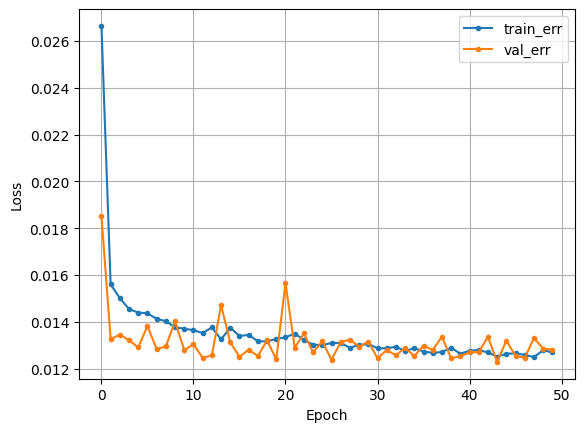

In [316]:
dl_history_plot(hist_DNN_3)

In [317]:
pred = model_DNN_3.predict(x_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 5ms/step


In [318]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 3023.099959309896
MAPE: 8.869110123393101e+17
R2  : -0.24483377895546288


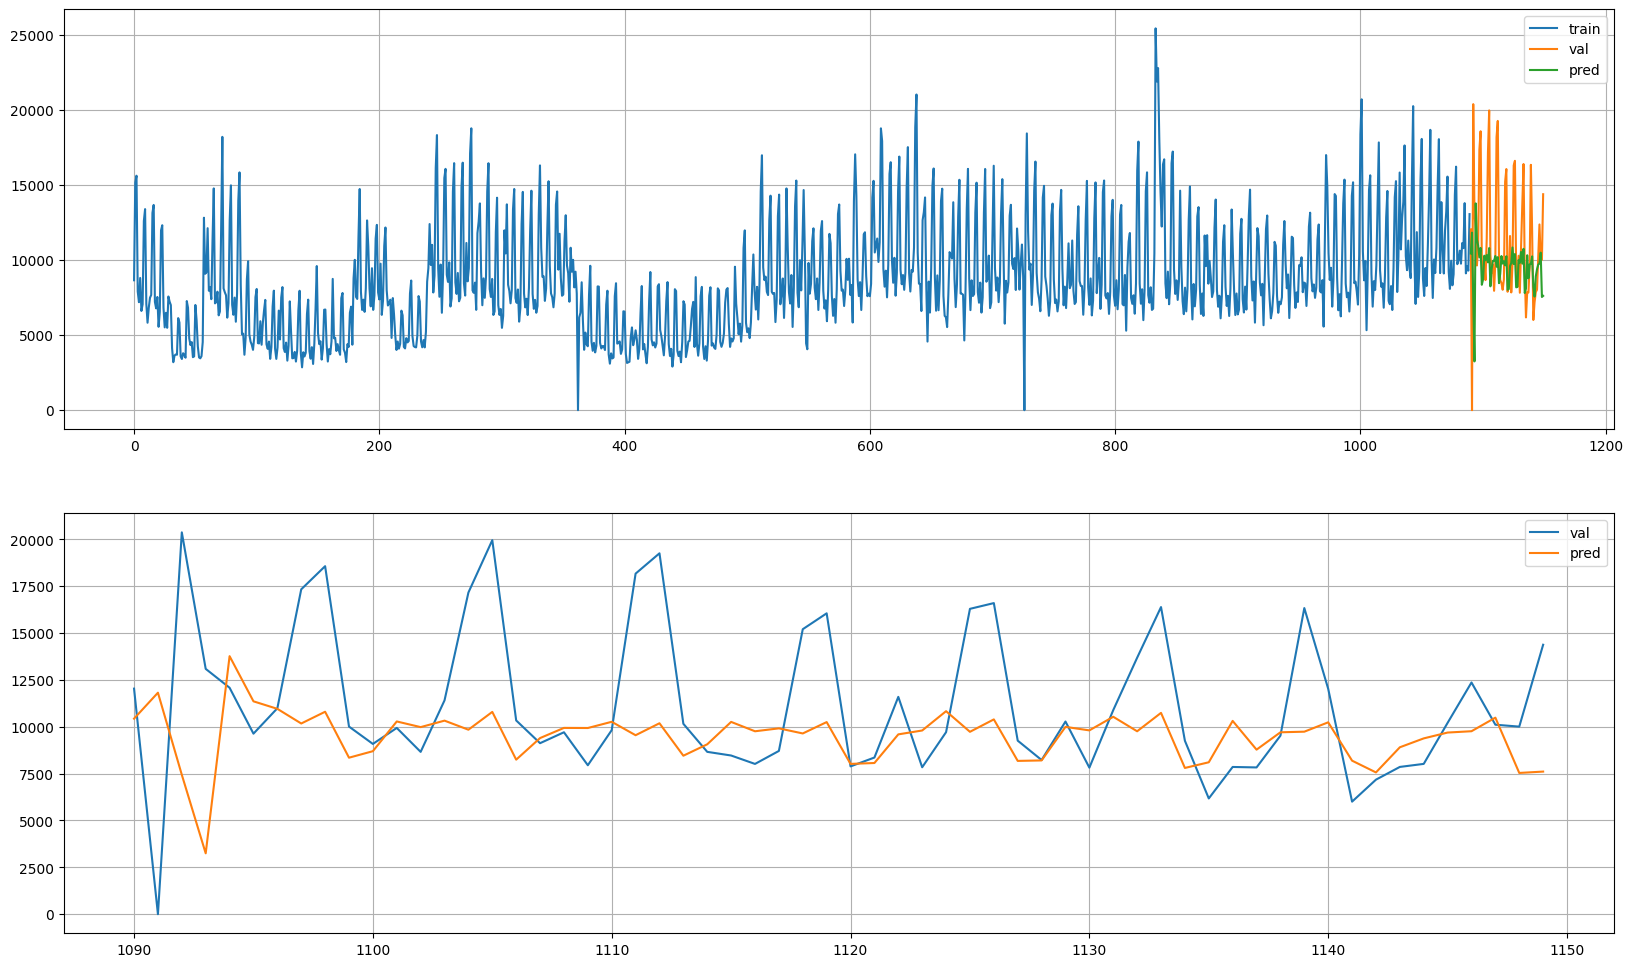

In [321]:
plot_model_result(y_train, y_val, pred)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [213]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [218]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [254]:
x2, y2 = temporalize(x, y, 7)

In [255]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size = 60, shuffle = False)

In [256]:
# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s2 = scale(x_train, scaler)
x_val_s2 = scale(x_val, scaler)

In [257]:
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.reshape(-1,1))

* **모델링**

In [258]:
n_features = x_train_s2.shape[2]

clear_session()

model_LSTM_3 = Sequential([LSTM(100, input_shape = (7, n_features), activation='relu'),
                     Dropout(0.2),
                     Dense(30, activation='relu'),
                     Dense(5, activation='relu'),
                    Dense(1)])

model_LSTM_3.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

In [259]:
hist = model_LSTM_3.fit(x_train_s2, y_train_s2, epochs=30, validation_split=.2).history

Epoch 1/30
28/28 [==============================] - 3s 26ms/step - loss: 0.0274 - val_loss: 0.0127
Epoch 2/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0151 - val_loss: 0.0093
Epoch 3/30
28/28 [==============================] - 0s 9ms/step - loss: 0.0105 - val_loss: 0.0057
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0120 - val_loss: 0.0088
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0093 - val_loss: 0.0072
Epoch 6/30
28/28 [==============================] - 0s 9ms/step - loss: 0.0083 - val_loss: 0.0127
Epoch 7/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 8/30
28/28 [==============================] - 0s 9ms/step - loss: 0.0076 - val_loss: 0.0061
Epoch 9/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 10/30
28/28 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 11/30
28/28 

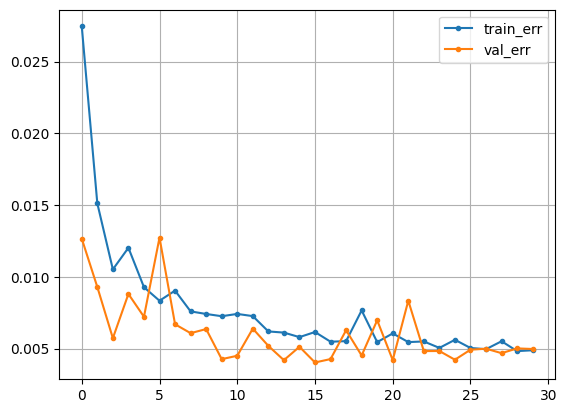

In [260]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [261]:
pred = model_LSTM_3.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 8ms/step


In [262]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 2126.505135091146
MAPE: 9.281844798227656e+17
R2  : 0.33136060078401575


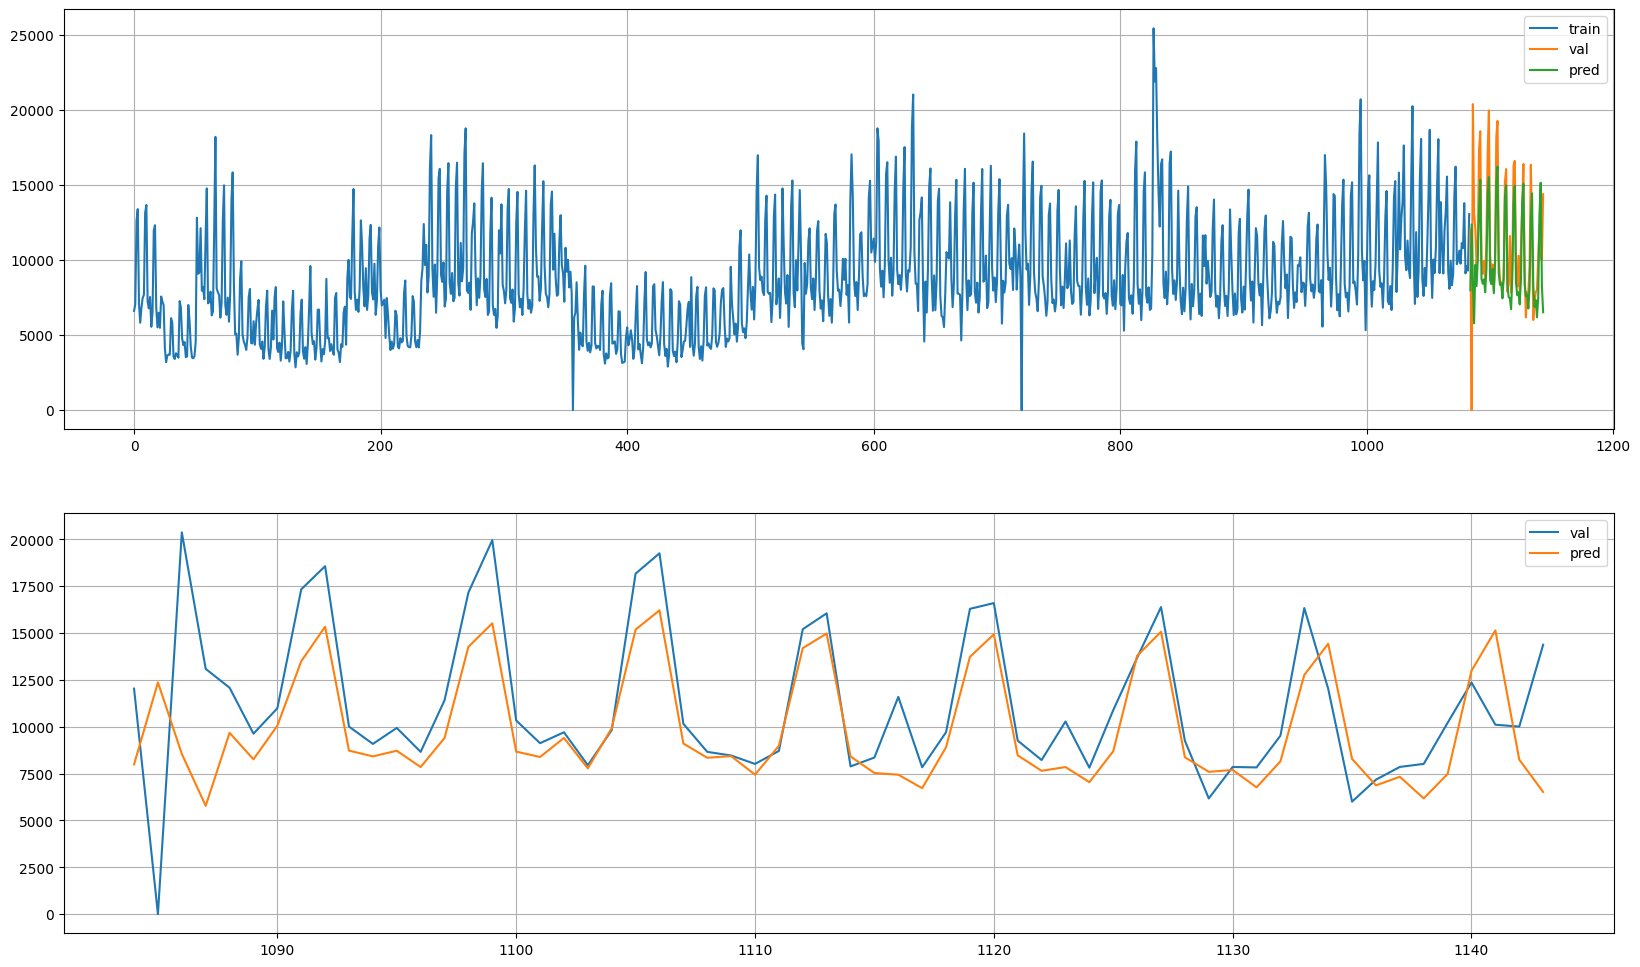

In [263]:
plot_model_result(y_train, y_val, pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [279]:
n_features = x_train.shape[2]

clear_session()

model_CNN_3 = Sequential([Conv1D(32, 5, input_shape = (7, n_features), activation='relu', padding = 'same'),
                    Conv1D(32, 5, activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(30, activation='relu'),
                    Dense(1)])

model_CNN_3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')

In [280]:
hist = model_CNN_3.fit(x_train_s2, y_train_s2, epochs=30, validation_split=.2).history

Epoch 1/30
28/28 [==============================] - 1s 10ms/step - loss: 0.1393 - val_loss: 0.0125
Epoch 2/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0170 - val_loss: 0.0114
Epoch 3/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0108 - val_loss: 0.0053
Epoch 4/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 5/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 6/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 7/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 8/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 9/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 10/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0062 - val_loss: 0.0091
Epoch 11/30
28/28 

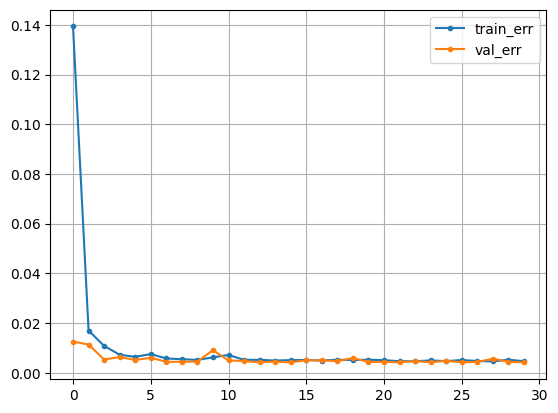

In [281]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [282]:
pred = model_CNN_3.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 5ms/step


In [283]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

MAE : 1864.4768880208333
MAPE: 1.1198451895115624e+18
R2  : 0.3569512088086234


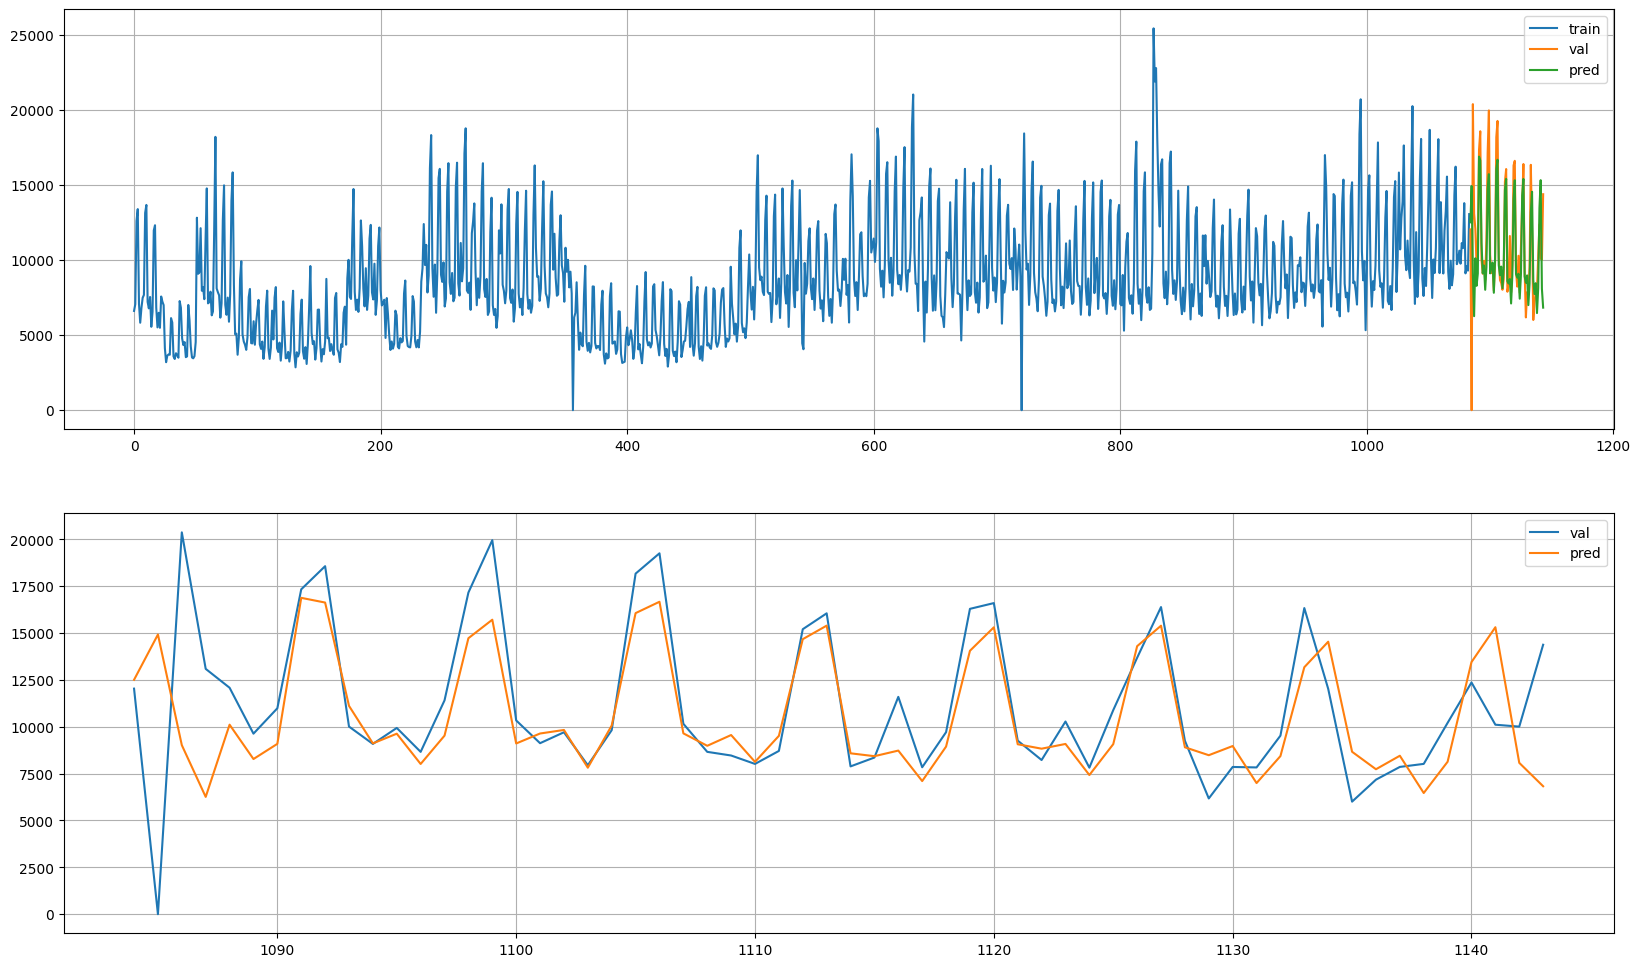

In [284]:
plot_model_result(y_train, y_val, pred)